In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('cleaned_file.csv')
df.head()
df["Rating"].describe()

count    207.000000
mean       4.164251
std        1.366051
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: Rating, dtype: float64

<Axes: >

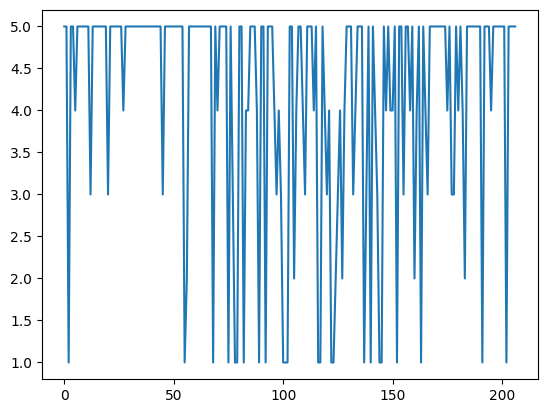

In [3]:
import matplotlib.pyplot as plt
df["Rating"].plot()

five: 134,
four:27,
three:16,
two:6,
one:24


<BarContainer object of 5 artists>

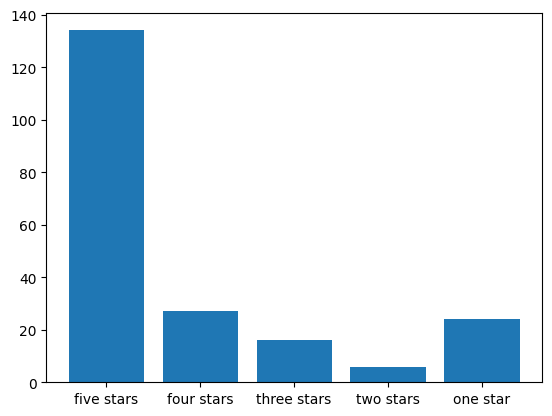

In [4]:
five=four=three=two=one=0
for i in range(len(df["Rating"])):
    if df["Rating"].iloc[i] == 5:
        five += 1
    elif df["Rating"].iloc[i] == 4:
        four += 1
    elif df["Rating"].iloc[i] == 3:
        three += 1    
    elif df["Rating"].iloc[i] == 2:
        two += 1
    elif df["Rating"].iloc[i] == 1:
        one+= 1

print(f"five: {five},\nfour:{four},\nthree:{three},\ntwo:{two},\none:{one}")
reviews = ["five stars","four stars","three stars","two stars","one star"]
counts = [five,four,three,two,one]
plt.bar(reviews,counts)


In [5]:
from transformers import MarianMTModel, MarianTokenizer

# Function to translate text
def translate(text, src_lang, tgt_lang):
    model_name = f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}"
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    
    # Tokenize and translate
    batch = tokenizer([text], return_tensors="pt", padding=True, truncation=True)
    translated = model.generate(**batch)
    return tokenizer.decode(translated[0], skip_special_tokens=True)



In [6]:
import pandas as pd
import torch
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
df = pd.read_csv("cleaned_file.csv")

# Load translation models
def load_translation_model(src_lang, tgt_lang):
    model_name = f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}"
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name).to(device)
    return model, tokenizer

# Translation function using updated tokenizer call
def translate(text, model, tokenizer):
    inputs = tokenizer([text], return_tensors="pt", padding=True, truncation=True).to(device)
    translated_tokens = model.generate(**inputs)
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text

# Load models once
en_fr_model, en_fr_tokenizer = load_translation_model("en", "fr")
fr_en_model, fr_en_tokenizer = load_translation_model("fr", "en")

# Back-translation function
def back_translate(text):
    if pd.isna(text) or text.strip() == "":
        return ""
    try:
        fr = translate(text, en_fr_model, en_fr_tokenizer)
        back_to_en = translate(fr, fr_en_model, fr_en_tokenizer)
        return back_to_en
    except Exception as e:
        print(f"Translation error: {e}")
        return text

# Apply back translation to all reviews
tqdm.pandas(desc="Augmenting reviews")
df['augmented_review'] = df['Review'].progress_apply(back_translate)

# Save final CSV
augmented_df = df[['Rating', 'augmented_review']].copy()
augmented_df.rename(columns={'augmented_review': 'Review'}, inplace=True)
augmented_df.to_csv("augmented_all_reviews.csv", index=False)

print("✅ All reviews augmented and saved to 'augmented_all_reviews.csv'")


Using device: cpu


Augmenting reviews: 100%|████████████████████████████████████████████████████████████| 207/207 [37:10<00:00, 10.77s/it]

✅ All reviews augmented and saved to 'augmented_all_reviews.csv'
